In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy as num
import seaborn as sns



#Read the csv, drop index column
df=pd.read_csv("fraud_payment_data.csv")


In [3]:
#Drop the rows with missing values
print("Number of total rows: ", len(df))
df = df.dropna()
print("Number of rows after dropping na: ", len(df))
df = df.drop(index=df[df['USD_amount'] == 0].index)
print("Number of rows after dropping USD_amount = 0: ", len(df))

df.info()
df.columns = df.columns.str.replace(' ', '_')

Number of total rows:  1498178
Number of rows after dropping na:  1063397
Number of rows after dropping USD_amount = 0:  1063375
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1063375 entries, 1 to 1498177
Data columns (total 13 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Time_step         1063375 non-null  object 
 1   Transaction_Id    1063375 non-null  object 
 2   Sender_Id         1063375 non-null  object 
 3   Sender_Account    1063375 non-null  object 
 4   Sender_Country    1063375 non-null  object 
 5   Sender_Sector     1063375 non-null  float64
 6   Sender_lob        1063375 non-null  object 
 7   Bene_Id           1063375 non-null  object 
 8   Bene_Account      1063375 non-null  object 
 9   Bene_Country      1063375 non-null  object 
 10  USD_amount        1063375 non-null  float64
 11  Label             1063375 non-null  float64
 12  Transaction_Type  1063375 non-null  object 
dtypes: float64(3), obj

In [4]:
# Agrupar el dataset por Sender_Account y contar el número de transacciones
num_transacciones = df.groupby("Sender_Account")["Transaction_Id"].agg(["count"])

# Renombrar la columna resultante para que se llame "Num_Transacciones"
num_transacciones = num_transacciones.rename(columns={"count": "Num_Transacciones"})
#print num_transacciones
num_transacciones.head()

,Num_Transacciones
Sender_Account,
ACCOUNT-100004,1
ACCOUNT-1000051,1
ACCOUNT-1000193,1
ACCOUNT-1000194,55
ACCOUNT-1000195,46


In [5]:
# Agrupar el dataset por Sender_Account y encontrar el valor máximo de la columna "FLAG"
flag = df.groupby("Sender_Account")["Label"].agg(["max"])

# Convertir los valores máximos a 1 o 0
flag["max"] = flag["max"].apply(lambda x: 1 if x == 1 else 0)

# Renombrar la columna resultante para que se llame "FLAG"
flag = flag.rename(columns={"max": "Label"})

# Unir los datos con el dataset original
df_accounts = pd.merge(num_transacciones, flag, on="Sender_Account")
df_accounts.head()

,Num_Transacciones,Label
Sender_Account,,
ACCOUNT-100004,1,0
ACCOUNT-1000051,1,0
ACCOUNT-1000193,1,0
ACCOUNT-1000194,55,1
ACCOUNT-1000195,46,0


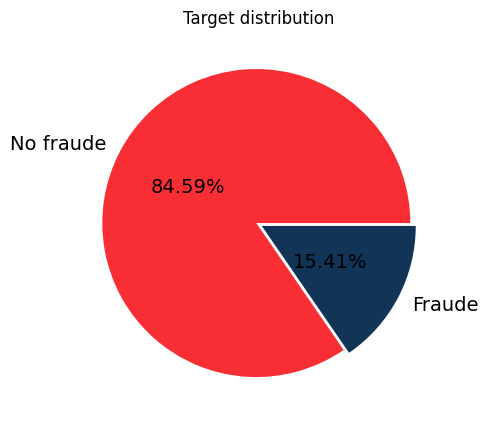

In [6]:
#Recuento de cuantas cuentas tienen transacciones fraudulentas
df_accounts["Label"].value_counts()


pie, ax = plt.subplots(figsize=[7,5])
labels = ['No fraude', 'Fraude']
colors = ['#f92e35', '#123456']
plt.pie(x = df_accounts["Label"].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

In [7]:
#muestra estadisticas de Num_Transacciones
df_accounts.describe()

,Num_Transacciones,Label
count,73999.000000,73999.000000
mean,14.370127,0.154083
std,16.597434,0.361031
min,1.000000,0.000000
25%,1.000000,0.000000
50%,8.000000,0.000000
75%,26.000000,0.000000
max,79.000000,1.000000


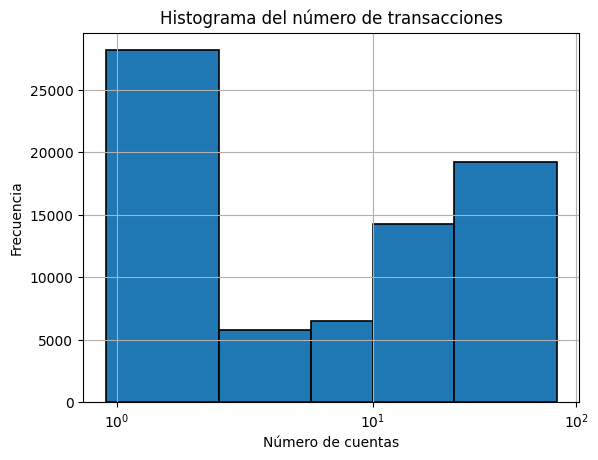

1        28193
25-80    18730
5-10     10806
10-25     9570
2-5       6700
Name: Num_Transacciones_discretized, dtype: int64

In [8]:
#crea bin con 0,2,5,10,25,80
bins = [0.9, 1.9, 5, 10, 25, 80]
#muestra histograma del número de transacciones
plt.xscale('symlog')
df_accounts["Num_Transacciones"].hist(bins=bins,align='mid',edgecolor='black', linewidth=1.2)
plt.title('Histograma del número de transacciones')
plt.xlabel('Número de cuentas')
plt.ylabel('Frecuencia')
plt.show()
#crea una nueva columna discretizando en los bins de antes
df_accounts['Num_Transacciones_discretized'] = pd.cut(df_accounts['Num_Transacciones'], bins=bins, labels=['1', '2-5', '5-10', '10-25', '25-80'])
#muestra estadisticas de la nueva columna
df_accounts['Num_Transacciones_discretized'].value_counts()


In [9]:
# Filtrar las filas que tienen Label=1
fraud = df[df["Label"] == 1]

# Agrupar el dataset filtrado por Sender_Account y encontrar el porcentaje de transacciones fraudulentas
perc_fraud = fraud.groupby("Sender_Account").agg({"Transaction_Id": "count", "Label": "sum"})
perc_fraud["Perc_Fraud"] = perc_fraud["Label"] / perc_fraud["Transaction_Id"]

# Renombrar la columna resultante para que se llame "Perc_Fraud"
perc_fraud = perc_fraud.rename(columns={"Perc_Fraud": "Perc_Fraud"})

# Unir los datos con el dataset original
df_accounts = pd.merge(df_accounts, perc_fraud, on="Sender_Account", how="left")

# Rellenar los valores NaN con 0
df_accounts["Perc_Fraud"] = df_accounts["Perc_Fraud"].fillna(0)
df_accounts.head(20)

,Num_Transacciones,Label_x,Num_Transacciones_discretized,Transaction_Id,Label_y,Perc_Fraud
Sender_Account,,,,,,
ACCOUNT-100004,1,0,1,NaN,NaN,0.0
ACCOUNT-1000051,1,0,1,NaN,NaN,0.0
ACCOUNT-1000193,1,0,1,NaN,NaN,0.0
ACCOUNT-1000194,55,1,25-80,1.0,1.0,1.0
ACCOUNT-1000195,46,0,25-80,NaN,NaN,0.0
ACCOUNT-1000196,9,0,5-10,NaN,NaN,0.0
ACCOUNT-1000198,1,0,1,NaN,NaN,0.0
ACCOUNT-1000199,21,1,10-25,1.0,1.0,1.0
ACCOUNT-1000200,1,0,1,NaN,NaN,0.0


In [10]:
#Drop first column
df = df.drop(df.columns[0], axis=1)
print(df.columns)

categories = df.select_dtypes('O').columns.astype('category')
df[categories]

for i in df.columns:
    print(f'Column --{i}-- has --{len(df[i].value_counts())}-- unique values')

df.describe()

a=(df.Label==1).value_counts()
print(a)

Index(['Transaction_Id', 'Sender_Id', 'Sender_Account', 'Sender_Country',
       'Sender_Sector', 'Sender_lob', 'Bene_Id', 'Bene_Account',
       'Bene_Country', 'USD_amount', 'Label', 'Transaction_Type'],
      dtype='object')
Column --Transaction_Id-- has --1063375-- unique values
Column --Sender_Id-- has --58423-- unique values
Column --Sender_Account-- has --73999-- unique values
Column --Sender_Country-- has --252-- unique values
Column --Sender_Sector-- has --50000-- unique values
Column --Sender_lob-- has --1-- unique values
Column --Bene_Id-- has --278068-- unique values
Column --Bene_Account-- has --293206-- unique values
Column --Bene_Country-- has --252-- unique values
Column --USD_amount-- has --100309-- unique values
Column --Label-- has --2-- unique values
Column --Transaction_Type-- has --4-- unique values
False    1041813
True       21562
Name: Label, dtype: int64


In [11]:
#Drop first column
df = df.drop(df.columns[0], axis=1)

Central tendency

In [12]:
np.random.seed(12356)

remove_n = 769000

drop_indices = np.random.choice(df.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
df_subset.describe()
print((df_subset.Label==1).value_counts())
arr=((df_subset.Label==1).value_counts()).to_numpy()

b= arr[1]/arr[0]

print("%:", b*100)

categories = df.select_dtypes('O').columns.astype('category')
df[categories]




False    288408
True       5967
Name: Label, dtype: int64
%: 2.068943996005659


,Sender_Id,Sender_Account,Sender_Country,Sender_lob,Bene_Id,Bene_Account,Bene_Country,Transaction_Type
1,JPMC-CLIENT-10098,ACCOUNT-10109,USA,CCB,CLIENT-10100,ACCOUNT-10106,CANADA,QUICK-PAYMENT
3,JPMC-CLIENT-9812,ACCOUNT-9825,USA,CCB,JPMC-CLIENT-9814,ACCOUNT-9824,USA,PAY-CHECK
5,JPMC-CLIENT-9763,ACCOUNT-9773,USA,CCB,JPMC-COMPANY-9765,ACCOUNT-9771,BELARUS,PAY-CHECK
10,JPMC-CLIENT-9229,ACCOUNT-9239,USA,CCB,COMPANY-9231,ACCOUNT-9237,QATAR,QUICK-PAYMENT
11,JPMC-CLIENT-9229,ACCOUNT-9240,USA,CCB,CLIENT-9247,ACCOUNT-9248,TANZANIA,MOVE-FUNDS
...,...,...,...,...,...,...,...,...
1498173,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,CCB,BILL-COMPANY-2179895,ACCOUNT-2179896,USA,MAKE-PAYMENT
1498174,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,QUICK-PAYMENT
1498175,JPMC-CLIENT-2179746,ACCOUNT-2179757,USA,CCB,BILL-COMPANY-2180022,ACCOUNT-2180023,USA,MAKE-PAYMENT
1498176,JPMC-CLIENT-2181147,ACCOUNT-2181158,USA,CCB,CLIENT-2181279,ACCOUNT-2181280,USA,QUICK-PAYMENT


In [13]:
for i in df_subset[categories].columns:
    print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()
large=df.nlargest(5, ['USD_amount'])
print(large)
df[numericals].var()


The categorical column --Sender_Id-- has --58423-- unique values
The categorical column --Sender_Account-- has --73999-- unique values
The categorical column --Sender_Country-- has --252-- unique values
The categorical column --Sender_lob-- has --1-- unique values
The categorical column --Bene_Id-- has --278068-- unique values
The categorical column --Bene_Account-- has --293206-- unique values
The categorical column --Bene_Country-- has --252-- unique values
The categorical column --Transaction_Type-- has --4-- unique values
                  Sender_Id   Sender_Account    Sender_Country  Sender_Sector  \
284027        CLIENT-415368   ACCOUNT-415384         SINGAPORE        44347.0   
1137088      CLIENT-1664521  ACCOUNT-1664522               USA        17398.0   
549956   JPMC-CLIENT-801171   ACCOUNT-801183               USA        40221.0   
1068317      CLIENT-1560717  ACCOUNT-1560718           MYANMAR        29013.0   
542984        CLIENT-796826   ACCOUNT-796840  FALKLAND-ISLANDS 

Sender_Sector    2.082015e+08
USD_amount       2.983459e+05
Label            1.986581e-02
dtype: float64

In [14]:
sorted_df = df.sort_values(by='USD_amount', ascending=False)
print(sorted_df.USD_amount)

284027     19927.99
1137088    19921.43
549956     19700.91
1068317    19699.39
542984     19629.81
             ...   
1096594        0.01
692555         0.01
229319         0.01
1266091        0.01
1472077        0.01
Name: USD_amount, Length: 1063375, dtype: float64


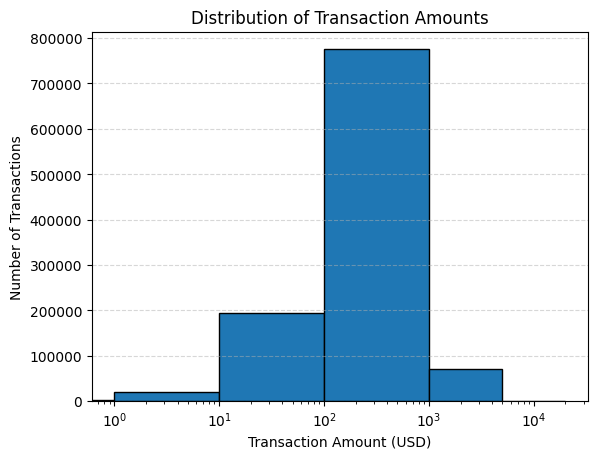

In [15]:

# Define the bin edges
bins = [0,1,10, 100, 1000, 5000,20000]
df=df.dropna()
# Plot the histogram
plt.hist(df['USD_amount'], bins=bins, align='mid',edgecolor='black')
# Set the x-axis scale to 'log'
plt.xscale('log')
# Set the axis labels and title

plt.xlabel('Transaction Amount (USD)')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transaction Amounts')
plt.grid(axis='y', alpha=0.5, linestyle='--')


plt.show()


Distribution by countries

In [16]:
# Statistics of top 10 Sender_Country
df['Sender_Country'].value_counts().head(10)


USA               805481
GERMANY            73362
CANADA             27296
FRENCH-GUIANA        996
THAILAND             985
LIECHTENSTEIN        982
MAURITANIA           973
KUWAIT               941
JAMAICA              919
CAYMAN-ISLANDS       897
Name: Sender_Country, dtype: int64

In [17]:
#Statistics only the fraud transactions
fraud=df[df['Label']==1]
fraud['Sender_Country'].value_counts().head(10)

USA                  16691
CANADA                 946
GERMANY                 49
SOUTH-SUDAN             38
EL-SALVADOR             37
GUAM                    36
MOZAMBIQUE              33
LIECHTENSTEIN           32
ITALY                   32
SAO-TOME-PRINCIPE       28
Name: Sender_Country, dtype: int64

In [18]:
#Statistics of top 10 Bene_Country
df['Bene_Country'].value_counts().head(10)

USA                 563692
CANADA              134351
GERMANY               7886
CAYMAN-ISLANDS        1843
BRAZIL                1817
INDIA                 1776
RUSSIAN               1774
SOUTH-SUDAN           1763
FRENCH-POLYNESIA      1746
GAMBIA                1730
Name: Bene_Country, dtype: int64

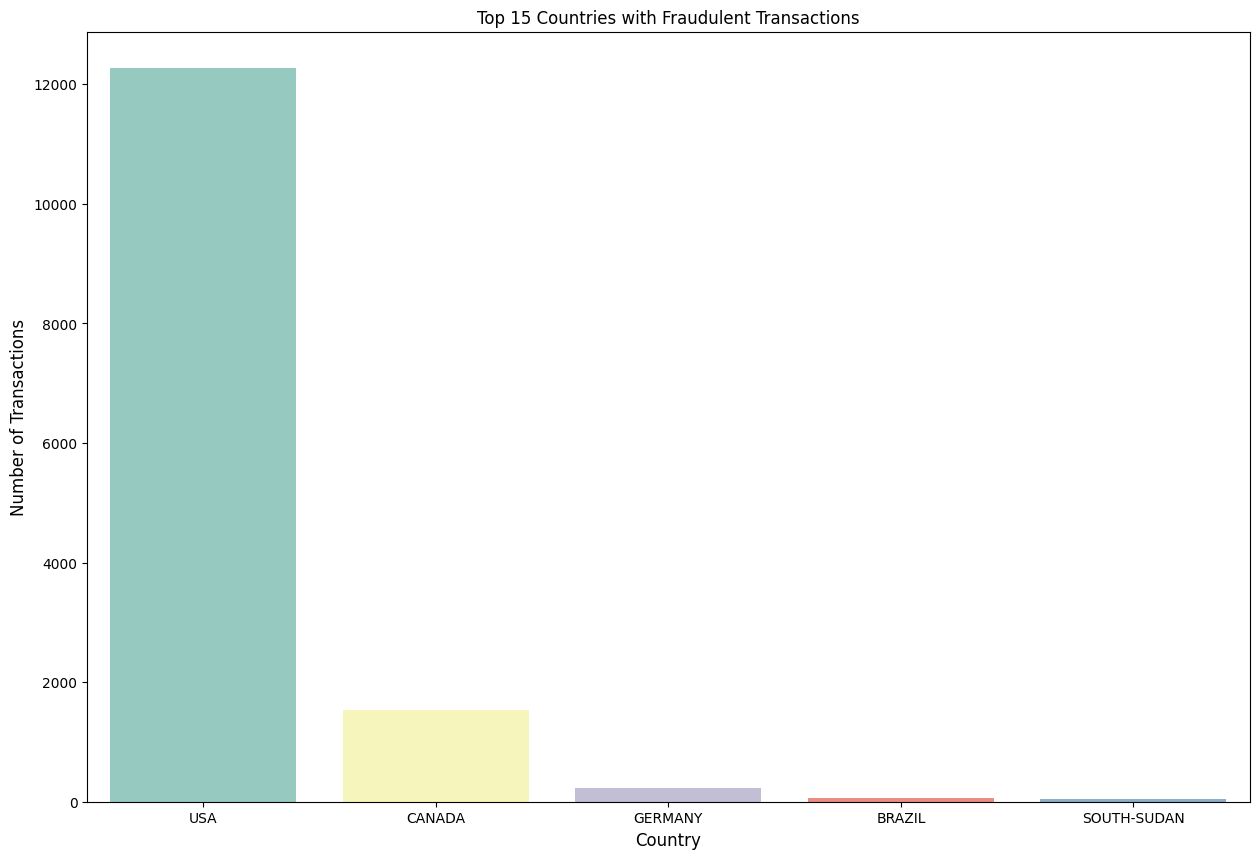

In [19]:

#in this cell we are going to create a bar chart showing the 15 top countries with the most fraudulant transactions
#First we get all the countries with fraudulant transactions
fraud_countries = df[df['Label'] == 1]['Bene_Country'].value_counts().head(5)
#Then we create a bar chart
plt.figure(figsize=(15,10))
sns.barplot(x=fraud_countries.index, y=fraud_countries.values, palette='Set3')
plt.title('Top 15 Countries with Fraudulent Transactions')
plt.ylabel('Number of Transactions', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

In [20]:
#make a dictionary with each column and its type
dtypes = dict(df.dtypes)
print(dtypes)


{'Sender_Id': dtype('O'), 'Sender_Account': dtype('O'), 'Sender_Country': dtype('O'), 'Sender_Sector': dtype('float64'), 'Sender_lob': dtype('O'), 'Bene_Id': dtype('O'), 'Bene_Account': dtype('O'), 'Bene_Country': dtype('O'), 'USD_amount': dtype('float64'), 'Label': dtype('float64'), 'Transaction_Type': dtype('O')}


               Sender_Sector  USD_amount     Label
Sender_Sector       1.000000    0.000013  0.000275
USD_amount          0.000013    1.000000  0.059918
Label               0.000275    0.059918  1.000000


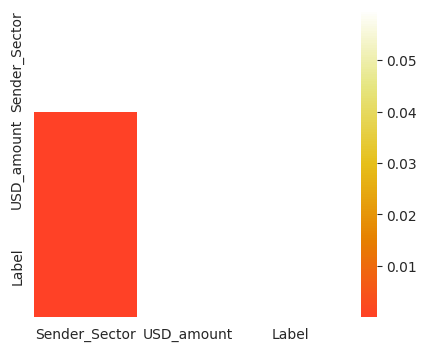

In [21]:
corr = df.corr()
print(corr)
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(5,4))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

In [24]:
#count all the rows which have missing value Null OR NaN in all of these columns: Sender_Id,Sender_Account,Sender_Country,Sender_Sector,Sender_lob
null_count = df['Sender_Id'].isnull().sum() 
print(null_count)

0
